In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [54]:
df = pd.read_csv("raw_data_with_labels.csv", index_col=0)
df=df[df['y'].notnull()]

In [55]:
df.shape

(498, 16)

In [56]:
df_limpo = pd.DataFrame(index=df.index)

In [57]:
clean_date = df['watch-time-text'].str.extract(r"(\d+) de ([a-z]+)\. de (\d+)")
clean_date[0] = clean_date[0].map(lambda x: "0"+x if len(x)==1 else x)

In [58]:
mapa_meses = {"jan":"Jan", "fev":"Feb", "mar":"Mar", "abr":"Apr", "mai":"May", "jun":"Jun","jul":"Jul", "ago":"Aug", "set":"Sep","out":"Oct","nov":"Nov","dez":"Dec"}
clean_date[1] = clean_date[1].map(mapa_meses)

In [59]:
clean_date = clean_date.apply(lambda x: " ".join(x), axis=1)

In [60]:
print(clean_date)

0      03 Sep 2018
1      16 Nov 2018
2      02 May 2019
3      13 Aug 2019
4      30 Nov 2018
          ...     
496    01 Mar 2018
497    31 May 2018
498    10 Nov 2019
499    25 Apr 2019
500    21 Mar 2019
Length: 498, dtype: object


In [61]:
df_limpo['date'] = pd.to_datetime(clean_date, format="%d %b %Y")

In [62]:
df_limpo

,date
0,2018-09-03
1,2018-11-16
2,2019-05-02
3,2019-08-13
4,2018-11-30
...,...
496,2018-03-01
497,2018-05-31
498,2019-11-10
499,2019-04-25


In [63]:
views = df['watch-view-count'].str.extract(r"(\d+\.?\d*)", expand=False).str.replace(".","").fillna(0).astype(int)

<ipython-input-63-80e92b4286bd>:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  views = df['watch-view-count'].str.extract(r"(\d+\.?\d*)", expand=False).str.replace(".","").fillna(0).astype(int)


In [64]:
df_limpo['views'] =views

In [65]:
df_limpo

,date,views
0,2018-09-03,28028
1,2018-11-16,1131
2,2019-05-02,1816
3,2019-08-13,1171
4,2018-11-30,1228
...,...,...
496,2018-03-01,170932
497,2018-05-31,69644
498,2019-11-10,470
499,2019-04-25,99855


In [66]:
features = pd.DataFrame(index=df_limpo.index)
y = df['y'].copy()

In [67]:
features['tempo_desd_pub'] = (pd.to_datetime("2021-02-13") - df_limpo['date'])/np.timedelta64(1, "D")
features['views'] = df_limpo['views']
features['views_por_dias'] = features['views'] / features['tempo_desd_pub']
features = features.drop(['tempo_desd_pub'], axis =1)

In [68]:
len(features)

498

In [80]:
features.head()

,views,views_por_dias
0,28028,31.351230
1,1131,1.379268
2,1816,2.781011
3,1171,2.129091
4,1228,1.523573


<AxesSubplot:>

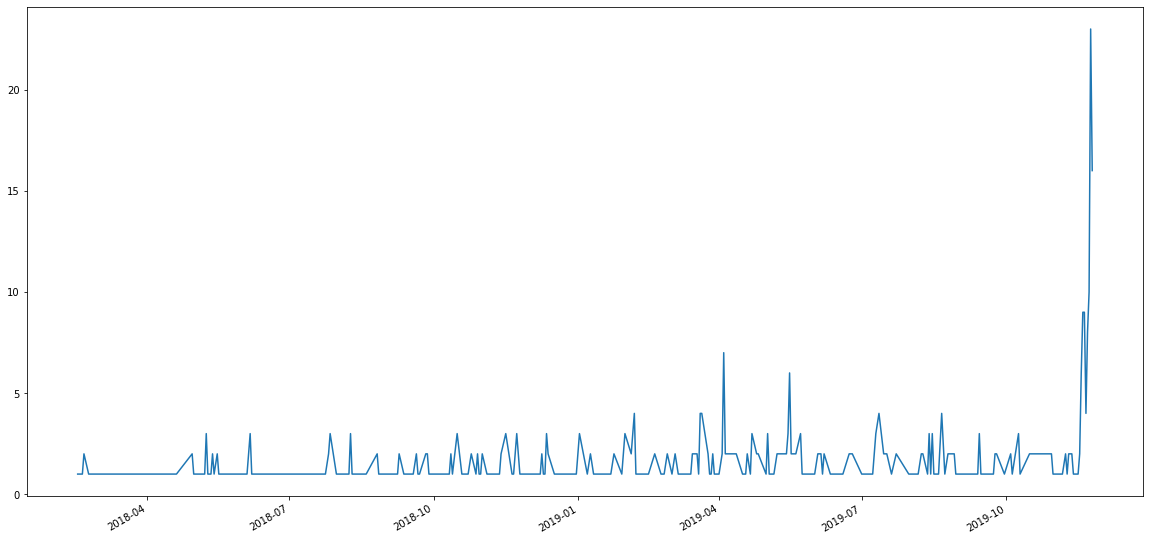

In [70]:
df_limpo['date'].value_counts().plot(figsize=(20,10))

In [81]:
X_train, X_val = features[df_limpo['date']<"2019-04-01"], features[df_limpo['date']>="2019-04-01"]
y_train, y_val = y[df_limpo['date']<"2019-04-01"], y[df_limpo['date']>="2019-04-01"]


In [151]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics 

In [83]:
y_train.sum()
len(y_train)

228

In [156]:
#classes desbalanceadas da um peso maior para classe positiva
#penalidade recebida pelo modelo quando comete um erro multiplica pelo peso maior para exxemplos positivos
mdl = DecisionTreeClassifier( max_depth=2, class_weight='balanced')
mdl.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=2)

In [157]:
#duas colunas primeira probabilidade de ser 0 e outra probabilidade de ser 1
p = mdl.predict_proba(X_val)[:, 1]

In [158]:
from sklearn.metrics import roc_auc_score, average_precision_score

In [159]:
#ranking
# se vc calcula a precisão e recall em cada ponto
# de todos os pontos que meu modelo disse ser positivos quantos ele acertos -precisão
# entre todas as classificações de classe Positivo em p que o modelo fez, quantas estão corretas;
# de todos os pontos que são positivos em yval quantos acertou o modelo
average_precision_score(y_val, p)

0.17022043550822075

In [160]:
#area sobre a curva do roc
#só exemplos positivos qual a probabilidade que atribuiu a eles de serem positivos
# negativos todos os exemplos que sabemos que são negativos e qual a probabilidade atribuida a ele de ser positivo pelo modelo
positivos=[0.1, 0.2, 0.3]
negativo = [0.1, 0.2, 0.5]
# aaleatoriaza pega um negativo e 1 positivo, AUC próximo do 0, o que significa que tem a pior medida de separabilidade, ou seja, está prevendo 0s como 1s e 1s como 0s
auc =roc_auc_score(y_val, p)

In [161]:
fpr, tpr, _ = metrics.roc_curve(y_val,  p)

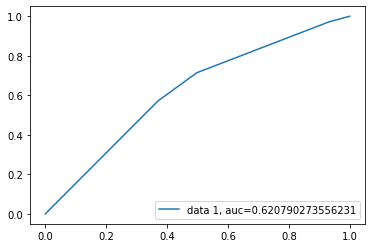

In [162]:
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [110]:
x = list(y_val)

In [164]:
index_positivos = []
index_negativos = []
for i in range(len(x)):
    if x[i]==1.0:
        index_positivos.append(i)
    else:
        index_negativos.append(i)      
roc_teste = []
for i in range(0, 10):
    tp = random.randint(0, len(index_positivos)-1)
    tn = random.randint(0, len(index_negativos)-1)
    negativo = index_negativos[tn]
    positivo = index_positivos[tp]

    if p[negativo] > p[positivo]:
        roc_teste.append(0)
    else: 
        roc_teste.append(1)  
sum(roc_teste)/len(roc_teste)

0.8

In [169]:
import pylab

In [165]:
from sklearn.tree import plot_tree

[Text(279.0, 453.0, 'views_por_dias <= 16.132\ngini = 0.5\nsamples = 228\nvalue = [114.0, 114.0]'),
 Text(139.5, 271.8, 'views <= 397.5\ngini = 0.478\nsamples = 130\nvalue = [60.49, 92.625]'),
 Text(69.75, 90.59999999999997, 'gini = 0.379\nsamples = 19\nvalue = [10.469, 3.562]'),
 Text(209.25, 90.59999999999997, 'gini = 0.461\nsamples = 111\nvalue = [50.02, 89.062]'),
 Text(418.5, 271.8, 'views <= 26712.0\ngini = 0.408\nsamples = 98\nvalue = [53.51, 21.375]'),
 Text(348.75, 90.59999999999997, 'gini = 0.0\nsamples = 23\nvalue = [13.378, 0.0]'),
 Text(488.25, 90.59999999999997, 'gini = 0.453\nsamples = 75\nvalue = [40.133, 21.375]')]

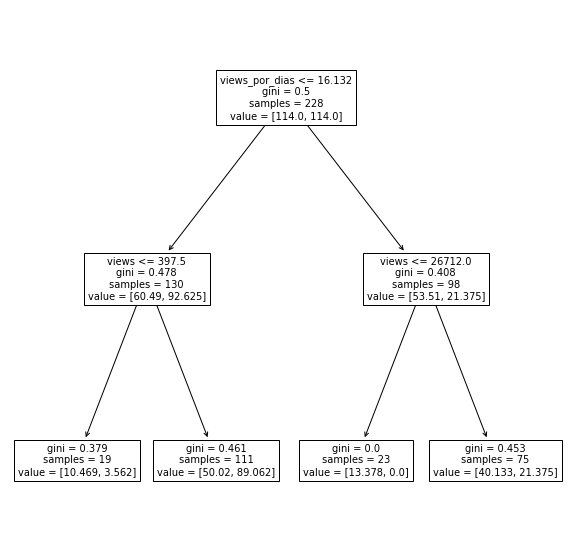

In [171]:
fig, ax = pylab.subplots(1,1, figsize=(10,10))
plot_tree(mdl, ax=ax, feature_names=X_train.columns)
# chance deu gostar é maior no campo value para classe positiva é maior